In [1]:
import scipy as sp
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['font.sans-serif'] = ['SimHei']

# 读取附件2中的数据
question_1_data = pd.read_excel('data.xlsx', sheet_name='附件2')
question_1_data = question_1_data.values

In [33]:
# 建立各个层的模型，用于后续计算
class Layer:
    def __init__(self, p, c, k, thickness=None):
        self.p = p
        self.c = c
        self.k = k
        self.thickness = thickness

# 赋值密度，比热，热传导率，厚度
layer_1 = Layer(300, 1377, 0.082, thickness=0.6)
layer_2 = Layer(862, 2100, 0.37)
layer_3 = Layer(74.2, 1726, 0.045, thickness=3.6)
layer_4 = Layer(1.18, 1005, 0.028)

In [34]:
# 微分方程组求解函数，通用于问题1,2,3的计算
def calculate(environment_temp=None, time=None,
              layer2_thick=None, layer4_thick=None,
              ke=None, ks=None):

    # 环境温度，皮肤温度
    ue = environment_temp
    us = 37.0

    # 赋值第II层，第IV层厚度
    layer_2.thickness = layer2_thick
    layer_4.thickness = layer4_thick

    # 对各层做分割
    div_1 = np.int(layer_1.thickness * 10)
    div_2 = np.int(layer_2.thickness * 10)
    div_3 = np.int(layer_3.thickness * 10)
    div_4 = np.int(layer_4.thickness * 10)

    delta_x1 = layer_1.thickness / div_1 / 1e3
    delta_x2 = layer_2.thickness / div_2 / 1e3
    delta_x3 = layer_3.thickness / div_3 / 1e3
    delta_x4 = layer_4.thickness / div_4 / 1e3

    # 时间步长
    delta_time = 1

    # 总时长
    total_time = time * 60

    # 各层热传导方程中的常量
    lamb_1 = (delta_time * layer_1.k) / \
             (layer_1.c * layer_1.p * np.square(delta_x1))
    lamb_2 = (delta_time * layer_2.k) / \
             (layer_2.c * layer_2.p * np.square(delta_x2))
    lamb_3 = (delta_time * layer_3.k) / \
             (layer_3.c * layer_3.p * np.square(delta_x3))
    lamb_4 = (delta_time * layer_4.k) / \
             (layer_4.c * layer_4.p * np.square(delta_x4))

    # 热对流边界方程中的常量
    miu_e = (ke * delta_x1) / layer_1.k
    miu_s = (ks * delta_x4) / layer_4.k
    miu_e_ue = miu_e * ue
    miu_s_us = miu_s * us

    # 三个交界面方程中的常量
    v_1 = layer_1.k / delta_x1
    v_2 = layer_2.k / delta_x2
    v_3 = layer_3.k / delta_x3
    v_4 = layer_4.k / delta_x4

    # 构造三对角稀疏矩阵
    dim = div_1 + div_2 + div_3 + div_4 + 1
    matrix_a = np.zeros(shape=(dim, dim), dtype='float32')
    matrix_a[0, 0] = 1 + miu_e
    matrix_a[0, 1] = -1
    matrix_a[-1, -1] = 1 + miu_s
    matrix_a[-1, -2] = -1

    matrix_a[div_1, div_1] = v_1 + v_2
    matrix_a[div_1, div_1 - 1] = -v_1
    matrix_a[div_1, div_1 + 1] = -v_2

    pos_1 = div_1 + div_2
    matrix_a[pos_1, pos_1] = v_2 + v_3
    matrix_a[pos_1, pos_1 - 1] = -v_2
    matrix_a[pos_1, pos_1 + 1] = -v_3

    pos_2 = pos_1 + div_3
    matrix_a[pos_2, pos_2] = v_3 + v_4
    matrix_a[pos_2, pos_2 - 1] = -v_3
    matrix_a[pos_2, pos_2 + 1] = -v_4

    for i in range(1, div_1):
        matrix_a[i, i] = 1 + 2 * lamb_1
        matrix_a[i, i - 1] = -lamb_1
        matrix_a[i, i + 1] = -lamb_1
    for i in range(1 + div_1, pos_1):
        matrix_a[i, i] = 1 + 2 * lamb_2
        matrix_a[i, i - 1] = -lamb_2
        matrix_a[i, i + 1] = -lamb_2
    for i in range(1 + pos_1, pos_2):
        matrix_a[i, i] = 1 + 2 * lamb_3
        matrix_a[i, i - 1] = -lamb_3
        matrix_a[i, i + 1] = -lamb_3
    for i in range(1 + pos_2, dim - 1):
        matrix_a[i, i] = 1 + 2 * lamb_4
        matrix_a[i, i - 1] = -lamb_4
        matrix_a[i, i + 1] = -lamb_4

    # 用于存储结果
    result = np.array([[37.0 for _ in range(dim)]], dtype='float32')

    # 解方程
    l, u = 1, 1
    matrix_ab = np.zeros(shape=(l + u + 1, dim), dtype='float32')
    matrix_b = np.zeros(shape=(dim, ), dtype='float32')
    matrix_b[0] = miu_e_ue
    matrix_b[-1] = miu_s_us
    for i in range(dim):
        for j in range(dim):
            if matrix_a[i, j] != 0:
                matrix_ab[u + i - j, j] = matrix_a[i, j]
    for t in range(1, total_time + 1):
        matrix_b[1: div_1] = result[t - 1][1: div_1]
        matrix_b[1 + div_1: pos_1] = result[t - 1][1 + div_1: pos_1]
        matrix_b[1 + pos_1: pos_2] = result[t - 1][1 + pos_1: pos_2]
        matrix_b[1 + pos_2: dim - 1] = result[t - 1][1 + pos_2: dim - 1]
        x = sp.linalg.solve_banded((l, u), matrix_ab, matrix_b)
        result = np.row_stack((result, x))
    return result

No handles with labels found to put in legend.
No handles with labels found to put in legend.


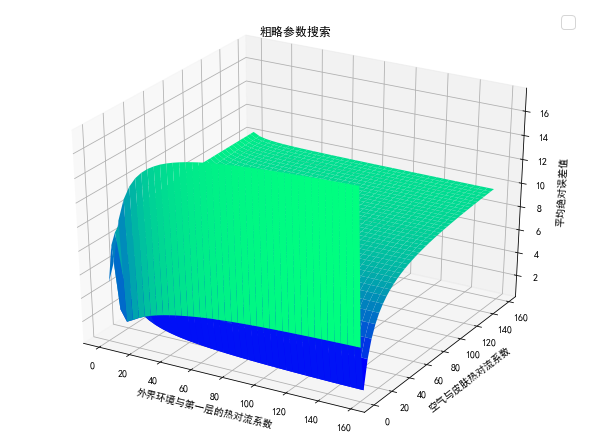

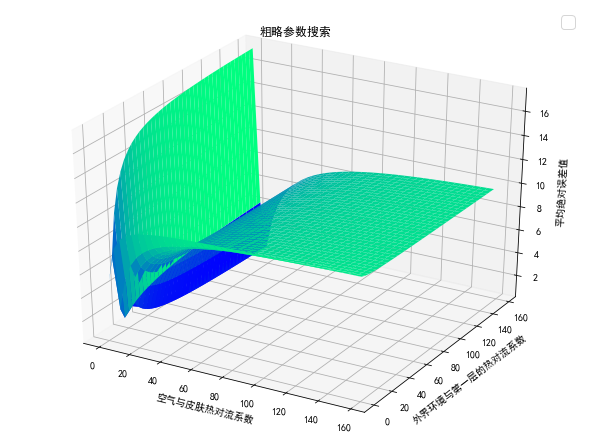

In [38]:
def problems_1():
    real_temp = question_1_data[:, -1]
    list_ke = []
    list_ks = []
    list_error = []
    start = 1
    stop = 160
    step = 4

    # 大步长搜索确定大致范围
    for ke in np.arange(start, stop, step):
        for ks in np.arange(start, stop, step):
            result = calculate(environment_temp=75.0, time=90,
                               layer2_thick=6, layer4_thick=5,
                               ke=ke, ks=ks)
            error = mean_absolute_error(real_temp, result[:, -1])
            list_ke.append(ke)
            list_ks.append(ks)
            list_error.append(error)

    # 搜索结果，误差分布图
    fig_1 = plt.figure(figsize=(8, 6))
    ax_1 = Axes3D(fig_1)
    ke_g = np.arange(start, stop, step)
    ks_g = np.arange(start, stop, step)
    error_g = np.reshape(list_error, newshape=(len(ke_g), len(ks_g)))
    ks_g, ke_g = np.meshgrid(ke_g, ks_g)
    ax_1.plot_surface(ks_g, ke_g, error_g, cmap='winter')
    ax_1.set_title('粗略参数搜索')
    ax_1.set_ylabel('外界环境与第一层的热对流系数')
    ax_1.set_xlabel('空气与皮肤热对流系数')
    ax_1.set_zlabel('平均绝对误差值')
    plt.legend(fontsize='xx-large')
    plt.savefig('参数搜索与误差分布图.png')
    plt.show()

    # # 根据粗略搜索所得最优进行精细搜索
    # step = 0.5
    # best_ke = list_ke[int(np.argmin(list_error))]
    # best_ks = list_ks[int(np.argmin(list_error))]
    # if best_ks - 4 <= 0:
    #     start = 0.5
    # min_error = min(list_error)
    # result_distribution = 0
    # for ke in np.arange(best_ke - 4, best_ke + 4, step):
    #     for ks in np.arange(start, best_ks + 4, step):
    #         result = calculate(environment_temp=75.0, time=90,
    #                            layer2_thick=6, layer4_thick=5,
    #                            ke=ke, ks=ks)
    #         error = mean_absolute_error(real_temp, result[:, -1])
    #         if error < min_error:
    #             min_error = error
    #             best_ke = ke
    #             best_ks = ks
    #             result_distribution = result
    #
    # print('最优热对流系数分别为:第一层与外界：{}, 空气与皮肤：{}'.format(best_ke, best_ks))
    #
    # # 温度分布三维图
    # result_distribution = np.round(result_distribution)
    # space_g, time_g = np.meshgrid(range(1, result_distribution.shape[1] + 1), range(1, result_distribution.shape[0] + 1))
    # fig_2 = plt.figure(figsize=(8, 6))
    # ax_2 = Axes3D(fig_2)
    # ax_2.plot_surface(space_g, time_g, result_distribution, cmap='coolwarm')
    # ax_2.set_title('温度分布')
    # ax_2.set_xlabel('空间轴')
    # ax_2.set_ylabel('时间轴')
    # ax_2.set_zlabel('温度')
    # plt.legend(fontsize='xx-large')
    # plt.savefig('分布图.png')
    # plt.show()
    #
    # # 温度分布二维图，抽取部分位置点
    # x1 = result_distribution[:, 2]
    # x2 = result_distribution[:, 60]
    # x3 = result_distribution[:, 100]
    # x4 = result_distribution[:, 130]
    # x5 = result_distribution[:, -1]
    # time_x = range(len(x1))
    # ax_3 = plt.figure(figsize=(8, 4.8)).gca()
    # ax_3.plot(time_x, x1, color='red', label='位置2（第一层临界）')
    # ax_3.plot(time_x, x2, color='blue', label='位置60')
    # ax_3.plot(time_x, x3, color='yellow', label='位置100')
    # ax_3.plot(time_x, x4, color='violet', label='位置130')
    # ax_3.plot(time_x, x5, color='green', label='位置153（皮肤处）')
    # ax_3.set_xlabel('时间轴')
    # ax_3.set_ylabel('温度轴')
    # ax_3.set_title('部分空间位置温度分布')
    # plt.legend()
    # plt.savefig('温度分布二维图.png')
    # plt.show()
    #
    # # 温度分布写入Excel
    # project = pd.DataFrame(result_distribution)
    # writer = pd.ExcelWriter('problem1.xlsx')
    # project.to_excel(writer, float_format='%.2f')
    # writer.save()
    # writer.close()

problems_1()

In [31]:
def problem_2():
    ke = 156.5
    ks = 8.5

    # 根据附件中所给范围，设定搜索范围及步长
    start = 0.6
    stop = 25
    step = 0.2

    # 设置搜索优化的指标，目标
    best_thick = 0
    best_temp = 44.0
    best_skin_temp = 47.0
    five_s = 300

    for thick in np.arange(start, stop, step):
        result = calculate(environment_temp=65.0, time=60,
                           layer2_thick=thick, layer4_thick=5.5,
                           ke=ke, ks=ks)

        # 第55分钟处皮肤处温度
        five_min_temp = result[-five_s, -1]
        skin_temp = result[-1, -1]
        if five_min_temp <= best_temp and skin_temp <= best_skin_temp:
            best_temp = five_min_temp
            best_skin_temp = skin_temp
            best_thick = thick
            break
    print('第II层最优厚度为：{}mm'.format(best_thick))
    print('此厚度下55分钟时皮肤外侧温度为：{}度'.format(best_temp))
    print('此厚度下60分钟时皮肤外侧温度为：{}度'.format(best_skin_temp))

problem_2()


第II层最优厚度为：17.60000000000001mm
此厚度下55分钟时皮肤外侧温度为：43.997108459472656度
此厚度下60分钟时皮肤外侧温度为：44.06452178955078度


In [36]:
def problem_3():
    ke = 156.5
    ks = 8.5

    # 设置搜索范围，步长
    start_2 = 0.6
    stop_2 = 25
    start_4 = 0.6
    stop_4 = 6.4
    step = 0.2

    # 设置搜索优化指标，目标
    best_thick_2 = 0
    best_thick_4 = 0
    best_temp = 44.0
    best_skin_temp = 47.0
    five_s = 300
    over = 0

    # 若要厚度最小，则应优先以第二层厚度小为目标
    print('正在搜索II，IV层厚度最优组合....')
    for thick_2 in np.arange(start_2, stop_2, step):
        for thick_4 in np.arange(start_4, stop_4, step):
            result = calculate(environment_temp=80.0, time=30,
                               layer2_thick=thick_2, layer4_thick=thick_4,
                               ke=ke, ks=ks)

            # 25分钟皮肤处温度
            five_min_temp = result[-five_s, -1]
            skin_temp = result[-1, -1]
            if five_min_temp <= best_temp and skin_temp <= best_skin_temp:
                best_thick_2 = thick_2
                best_thick_4 = thick_4
                best_temp = five_min_temp
                best_skin_temp = skin_temp
                over = 1
                break
        if over:
            break

    # 输出结果
    print('搜索完成！')
    print('第二层最优厚度：{}mm'.format(best_thick_2))
    print('第四层最优厚度：{}mm'.format(best_thick_4))
    print('此厚度组合下，25分钟时皮肤外侧温度：{}'.format(best_temp))
    print('此厚度组合下，30分钟时皮肤外侧温度：{}'.format(best_skin_temp))







第二层最优厚度：19.40000000000001mm
第四层最优厚度：6.600000000000001mm
此厚度组合下，25分钟时皮肤外侧温度：43.999149322509766
此厚度组合下，30分钟时皮肤外侧温度：44.7697639465332
